# Draft Ignacio Loayza C.
### Importante: Este trabajo es un borrador, no debe ser utilizado para la evaluación final.
### Observación: Este informe está hecho para ser leido en su formato .html, por favor descargarlo utilizando esta extensión para una mejor lectura.

## Resumen Ejecutivo
> El presente informe responde a la necesidad de un estudio estadístico y analítico sobre los clientes del grupo SMU, específicamente, sobre el uso de la tarjeta *Unicard* la cual permite acceder a una serie de beneficios a su propietario, dentro de este contexto se estudió el uso de del sistema *Unired* para el pago de cuentas fijandose tres objetivos: Primero, encontrar correlaciones en el comportamiento de compras entre clientes en Unimarc y el medio de pago, obteniendose el perfil de lo que se espera de un buen cliente. Segundo, obtener un modelo que permita detectar a potenciales buenos clientes y ayude a tomar decisiones con respecto a él. Tercero, determinar las motivaciones de un cliente para usar o no la tarjeta *Unicard*.
Los resultados del estudio revelan...


## I) Contexto del problema
> La Tarjeta de Crédito Unicard forma parte de SMU y es un medio de financiamiento para los clientes de Unimarc, permitiéndoles acceder a beneficios y descuentos exclusivos.<br>

> La estrategia de negocio se enfoca en el uso de datos para la toma de decisiones por lo que se requiere de equipos altamente especializados en el manejo de gran volumen de datos y en técnicas avanzadas para distintos análisis de segmentación de clientes, identificación de patrones, modelos predictivos, etc. Uno de los desafíos comerciales que se pueden abordar desde un enfoque analítico es aprovechar los datos transaccionales que se generan en los distintos negocios del retail y construir distintos modelos analíticos, éste será el objetivo de el análisis realizado.

## I.a) Objetivos

> Responder a las siguientes preguntas de interés:<br>

> 1.- Encontrar correlaciones entre la información de comportamiento de compras de los clientes en los locales de Unimarc y el uso del medio de pago Unicard con el fin de identificar prospectos o perfiles de mejores clientes.<br>

> 2.- Identificar posibles indicadores en base al comportamiento de pago de cuentas en Unired de clientes sin información bancaria disponible. Estos deben ser capaces de evaluar a los clientes sin tarjeta para determinar la factibilidad de apertura con el fin de aumentar la cartera actual minimizando el riesgo.<br>

> 3.- Para clientes de tarjeta Unicard, usando comportamientos de compras en el retail y en el portal de pago de servicios, determinar principales palancas que determinan el uso de la tarjeta para el pago de sus compras en Unimarc.

## I.b) Estrategia
> Nuestra estrategia de ataque estará basada en el modelo CRISP_DM, por lo que los pasos serán:<br>

> **1.- Entender el dominio y factibilidad del problema mediante análisis discriptivo y exploratorio de los datos. <br>**

> **2.- Discutir relaciones interesantes entre columnas y preparar los datos para el modelamiento.**

> **3.- Generar modelos que permitan responder las preguntas requeridas en los objetivos.**

## I.c) Ingestión de datos y consideraciones especiales
> Los datos utilizados forman parte de un extracto de la base de datos de la organización interesada, según se informó, el volumen de datos entregado corresponde a cerca del 10% del total contenido en la base de datos original.<br>
Se debe hacer notar que debido probablemente a los mecanismos de extracción utilizados para generar el subconjunto de datos entregados, se encontraron numerosas inconsistencias, problemas de redundancia en las tablas, claves primarias repetidas, entre otros. Se hace mención a estos problemas debido a que, a pesar de que fueron limpiados tanto como se pudo, pueden ser origen de sesgo en la muestra debido a replicaciones, se asume entonces que el sesgo y error 

In [205]:
%matplotlib inline
# Imports

#estadistica y estructuras de datos
import pandas as pd
import numpy as np

#machine learning
import sklearn as sklearn
from sklearn.metrics import mean_squared_error

# normalizacion
from sklearn.preprocessing import StandardScaler

# regresion lineal
import sklearn.linear_model as lm

# division del conjunto en entrenamiento y testing: Standby hasta tener los permisos
from sklearn.model_selection import train_test_split

# Cross Validation: Standby hasta tener los permisos
from sklearn.model_selection import KFold

# Clasificador RandomForest
from sklearn.ensemble import RandomForestClassifier

# en algun momento argumentamos a favor del coeficiente de determinacion como metrica valida
from sklearn.metrics import r2_score

# regularizacion
from sklearn.linear_model import Ridge, Lasso

# comparacion de precision
from sklearn.metrics import accuracy_score

# memory cache
from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose = 0)

# graficas
import seaborn as sn
sn.set_style("darkgrid")

# database connection
from ibmdbpy import IdaDataBase, IdaDataFrame

# errores y cosas para calcular z-scores
from numpy.linalg import pinv

# graficos
import matplotlib.pyplot as plt


#sets
import collections
from collections import Counter

# Warnings
import warnings
warnings.filterwarnings('ignore')

#HTML incrustation
from IPython.display import display, HTML

################### Funciones Utiles ###########################
def lindo_codigo(dataframe):
    dataframe.info()
    print()

@memory.cache
def count_diff_df(df, column_list):
    set_for_plot = {}
    for column in column_list:
        if column in df.columns:
            c = Counter(df[column])
            column_types = list(c.keys())
            column_count = list(c.values())
            set_for_plot.update({column:(column_types,column_count)})
    return set_for_plot

#Para centrar tablas y gráficos
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

In [157]:
# Conexion a la BD
conn = IdaDataBase(dsn='DASHDB;Database=BLUDB;Hostname=169.60.7.80;Port=50000;PROTOCOL=TCPIP;UID=equipo03;PWD=@NyanculefEsMiPastor2')
# @hidden_cell
# This connection object is used to access your data and contains your credentials.
# You might want to remove those credentials before you share your notebook

#Voy a descargar las tablas de la DB para poder trabajarlas y hacer el analisis correspondiente
df_unicard = IdaDataFrame(conn, 'BLUADMIN.UNICARD').as_dataframe()
df_catalogo = IdaDataFrame(conn, 'BLUADMIN.CATALOGO_TOTAL').as_dataframe()
df_comTotal = IdaDataFrame(conn, 'BLUADMIN.COMPANY_TOTAL').as_dataframe()
df_centros = IdaDataFrame(conn, 'BLUADMIN.CENTROS').as_dataframe()
df_item = IdaDataFrame(conn, 'BLUADMIN.ITEM').as_dataframe()
df_retail = IdaDataFrame(conn, 'BLUADMIN.PERSONA').as_dataframe()
df_ready = IdaDataFrame(conn, 'equipo03.TABLA1').as_dataframe()

# You can close the database connection with the following code. Please keep the comment line with the @hidden_cell tag,
# because the close function displays parts of the credentials.
# @hidden_cell
# idadb_52c624011cf2483c93b7b45adcd90438.close()
# To learn more about the ibmdby package, please read the documentation: http://pythonhosted.org/ibmdbpy/


In [160]:
#Preprocesamiento y exploración
df_ready.describe()

,PERSONA_ID,EDAD,TIENE_MOVIL,TIENE_CORREO,CANT_COMPRAS,VOL_COMPRAS,CANT_COMPRAS_DESC,CANT_COMPRAS_UNICARD,DESC_PORC,DESC_MONTO,TIENE_TARJETA,BLOQUEO,CUPO,CANT_TRX,VOL_TRX
count,5.552400e+05,538295.000000,555240.000000,555240.000000,555240.000000,5.552400e+05,555240.000000,555240.000000,555240.000000,5.552400e+05,555240.000000,555240.000000,5.552400e+05,555240.000000,5.486420e+05
mean,4.997258e+07,43.022863,0.807856,0.209086,5.245420,6.197252e+04,3.115545,0.061314,0.128648,6.620906e+03,0.006478,0.002840,1.741903e+03,2.573647,9.383816e+04
std,2.884562e+07,15.017411,0.393986,0.406656,20.227822,2.644903e+05,15.001369,1.901917,0.260791,3.727160e+04,0.080227,0.053218,2.788749e+04,8.169862,8.319501e+05
min,1.010000e+02,18.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-0.008950,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,2.509202e+07,NaN,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,NaN
50%,4.997142e+07,NaN,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,NaN
75%,7.497357e+07,NaN,1.000000,0.000000,3.000000,2.648000e+04,2.000000,0.000000,0.149031,1.637000e+03,0.000000,0.000000,0.000000e+00,1.000000,NaN
max,9.999996e+07,130.000000,1.000000,1.000000,3383.000000,6.671780e+07,2191.000000,242.000000,10.818502,8.595242e+06,1.000000,1.000000,2.204428e+06,698.000000,2.196665e+08


## I.- Análisis Descriptivo y Exploratorio

Comenzaremos el análisis explorando los valores almacenados sobre los cupos y movimientos o bloqueos de las cuentas de aquellas personas que poseen la tarjeta *Unicard*.

In [228]:
df_unicard_test = df_unicard
#limpieza de la hora y conversion a fecha nuevamente
df_unicard_test['FECHA_APERTURA'] = pd.to_datetime(df_unicard_test['FECHA_APERTURA'].values).strftime("%Y-%m")

unicard_counter = Counter(df_unicard_test['FECHA_APERTURA'])

df = pd.DataFrame()
df['Numero de registros'] = list(unicard_counter.values())
df['Fecha'] = list(unicard_counter.keys())
df = df.sort_values(by = 'Fecha')
df.set_index('Fecha');
#Reemplazo de valores mal almacenados
df_unicard.replace(to_replace={'BLOQUEO':{1:'Si'}}, inplace = True);
df_unicard.replace(to_replace={'BLOQUEO':{0:'No'}}, inplace = True);

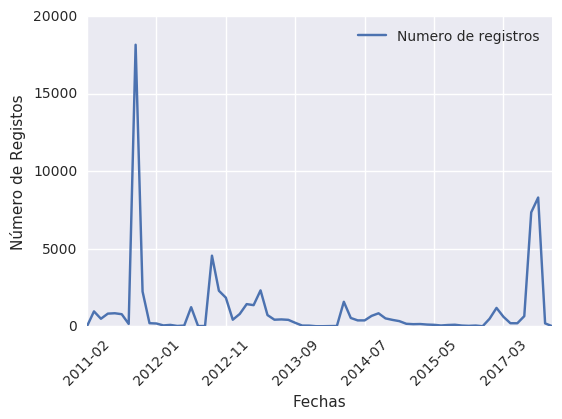

In [229]:
df[['Fecha','Numero de registros']].set_index('Fecha').plot();
plt.xticks(rotation = 45);
plt.xlabel("Fechas");
plt.ylabel("Número de Registos");
#insert just right grafico meme

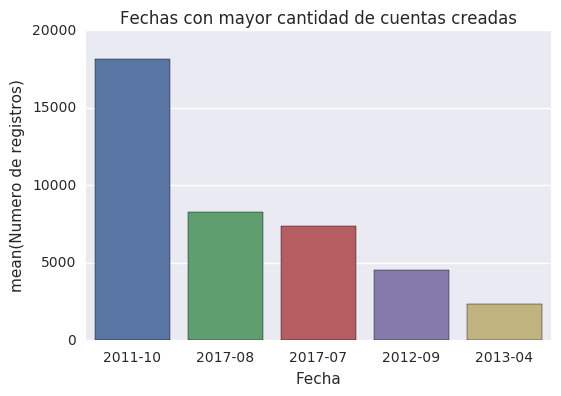

In [289]:
plt.title("Fechas con mayor cantidad de cuentas creadas")
bp = pd.DataFrame(df.sort_values(by='Numero de registros', ascending = False).head(5));
sn.barplot(x = bp['Fecha'], y = bp['Numero de registros']);

> Claramente hay ciertos períodos en los que la creación de cuentas en la tarjeta *Unicard* se dispara, las cinco fechas más populares se muestran en el gráfico anterior, estas son:<br>
> - **Octubre del 2011:** 18167 cuentas creadas.
> - **Agosto del 2017:** 8309 cuentas creadas.
> - **Julio del 2017:** 7354 cuentas creadas.
> - **Septiembre del 2012:** 4556 cuentas creadas.
> - **Junio del 2013:** 2320 cuentas creadas.



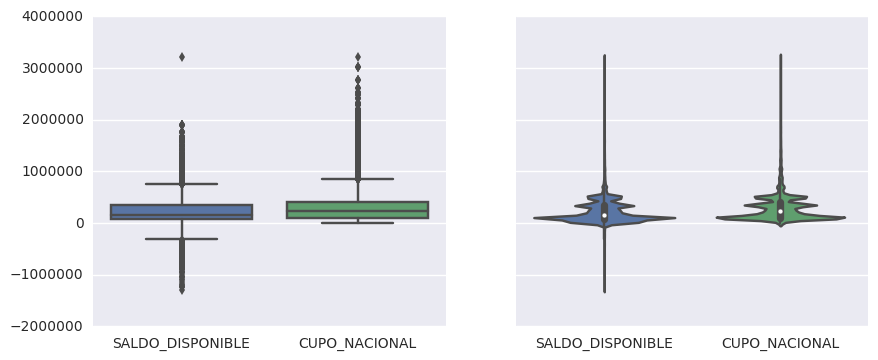

In [213]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4));
#ax1 = fig.add_subplot(121);
#ax2 = fig.add_subplot(122,sharey = ax1);
#ax = sn.swarmplot(data=df_unicard[['SALDO_DISPONIBLE','CUPO_NACIONAL']]);
sn.boxplot(data = df_unicard[['SALDO_DISPONIBLE','CUPO_NACIONAL']],ax = ax1);
sn.violinplot(df_unicard[['SALDO_DISPONIBLE','CUPO_NACIONAL']],ax = ax2);


>La distribución de valores de la variable de cupo nacional debiesen distribuirse de forma menos continua que el saldo de la cuenta (a una persona persona se le incrementa su cupo en cantidades del orden de las decenas a centenas de miles de pesos), lo que permite a los valores del saldo distirbuirse y concentrarse en ciertos valores con mayor facilidad que el cupo nacional, sin embargo, de las gráficas anteriores se puede ver que el saldo disponible y el cupo se distribuyen de forma similar, además se observa que:
> - La media del saldo que las personas tienen disponible para compra en un determinado momento está cercano a los \$216,000 sobre un cupo nacional medio de \$297,000, lo que indica que en promedio las personas utilizan cerca de $\frac{8}{11}$ del cupo total disponible que poseen.
> - Menos de un 25\% de las personas tienen un cupo nacional menor a \$80,442.
> - La mitad de los clientes poseen un cupo nacional igual o mayor a \$230,000.
> - Al parecer hay una cantidad no despreciable de personas que se alejan los valores de saldo disponible y cupo nacional, sin embargo, el 50\% de las personas maneja saldos en sus cuentas de entre \$80,000 y \$350,000 aproximadamente, mientras que para el caso del cupo nacional se observa que un 50\% se concentra entre los \$100,000 y \$400,000.

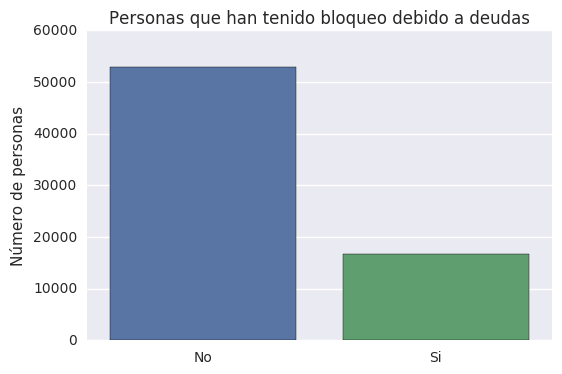

In [290]:
c = Counter(df_unicard['BLOQUEO'])
plt.title("Personas que han tenido bloqueo debido a deudas")
plt.ylabel("Número de personas")
sn.barplot(x = list(c.keys()), y = list(c.values()));


> - La cantidad de personas que han tenido bloquos es de tan solo 16,756, mientras que las que nunca han tenido su cuenta bloqueada asienden a 52,977.
> - El grupo de personas muestredo tiene una clara concentración de personas que pagan sus deudas de forma oportuna lo que indica que **en general los usuarios de la tarjeta *Unicard* pueden ser considerados buenos clientes**.

Al parecer hay un outlier interesante en los saldos disponibles

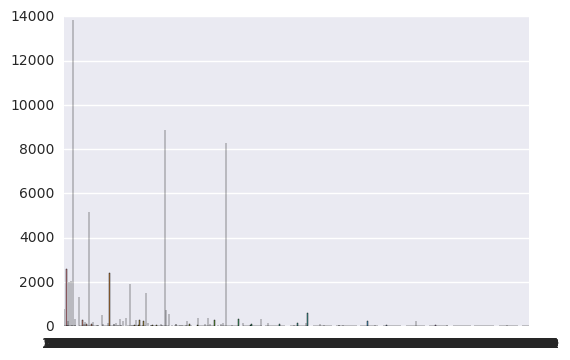

In [37]:
#f_apertura = collections.OrderedDict(sorted(count_diff_df(df_unicard,df_unicard.columns)['FECHA_APERTURA']))
#f_apertura.items()
#sn.barplot(count_diff_df(df_unicard,df_unicard.columns).keys(),count_diff_df(df_unicard,df_unicard.columns).values()[1])
#df_unicard['']pd.to_datetime(catalogo_counter.get('CAMPAIGN_START_DATE')[0], format = '%Y-%m-%d')
c = Counter(df_unicard['CUPO_NACIONAL'])
column_types = list(c.keys())
column_count = list(c.values())
sn.barplot(x=column_types,y=column_count)
plt.show()

In [ ]:
# OBS: Ejecutar esta celda requiere tener instalado graphviz

import graphviz
dot_data = tree.export_graphviz(tree_clf, out_file = None)
graph = graphviz.Source(dot_data)
graph.render("Wave")
dot_data = tree.export_graphviz(tree_clf, out_file=None,   
                         filled=True, rounded=True,  
                         special_characters=True,)  
graph = graphviz.Source(dot_data)
graph

### Dataset Procesado
Con el fin de obtener un producto de datos más homogéneo se generó el dataframe *df_ready*, creado a partir de una tabla sintética nacida de uniones de diferentes tablas de la base de datos, este dataframe concentra la información considerada relevante con respecto a una persona y que nos permitirá construir un modelo que recupere las características importantes de los perfiles de clientes que nos interesa, la estructura del dataframe se especifica en el anexo.<br>

In [10]:
df_ready.head()

,PERSONA_ID,GENERO,EDAD,TIENE_MOVIL,TIENE_CORREO,GSE,CIVIL,PROFESION,CANT_COMPRAS,VOL_COMPRAS,CANT_COMPRAS_DESC,CANT_COMPRAS_UNICARD,DESC_PORC,DESC_MONTO,TIENE_TARJETA,BLOQUEO,CUPO,CANT_TRX,VOL_TRX
0,59552982,FEMENINO,56.0,1,0,E,CASADO,DUENA DE CASA,1.0,8540.0,1.0,0.0,0.803044,6858.0,0,0,0,0.0,0.0
1,49591722,FEMENINO,28.0,1,0,None,SOLTERO,None,0.0,0.0,0.0,0.0,0.000000,0.0,0,0,0,15.0,231390.0
2,66368970,MASCULINO,36.0,1,0,E,CASADO,None,2.0,7243.0,1.0,0.0,0.040105,229.0,0,0,0,0.0,0.0
3,57980390,FEMENINO,55.0,1,0,E,CASADO,DUENA DE CASA,0.0,0.0,0.0,0.0,0.000000,0.0,0,0,0,0.0,0.0
4,77379116,MASCULINO,22.0,0,0,None,SOLTERO,None,0.0,0.0,0.0,0.0,0.000000,0.0,0,0,0,0.0,0.0


Se observan sintomas de datos sucios y no procesados, procederemos a limpiarlos prepararlos para el análisis.

In [11]:
@Memory.cache
df_ready.replace(to_replace={'TIENE_CORREO':{0:'No'}}, inplace = True);
df_ready.replace(to_replace={'TIENE_CORREO':{1:'Si'}}, inplace = True);
df_ready.replace(to_replace={'TIENE_MOVIL':{0:'No'}}, inplace = True);
df_ready.replace(to_replace={'TIENE_MOVIL':{1:'Si'}}, inplace = True);
df_ready.replace(to_replace={'BLOQUEO':{1:'Si'}}, inplace = True);
df_ready.replace(to_replace={'BLOQUEO':{0:'No'}}, inplace = True);
df_ready.replace(to_replace={'TIENE_TARJETA':{0:'No'}}, inplace = True);
df_ready.replace(to_replace={'TIENE_TARJETA':{1:'Si'}}, inplace = True);


In [13]:
df_ready_conTarjeta = df_ready[df_ready['TIENE_TARJETA']=='Si']
df_ready_sinTarjeta = df_ready[df_ready['TIENE_TARJETA']=='No']

In [ ]:
plt.title('Edades de clientes con y sin tarjeta')
plot_data = {
    "Ambos Grupos":df_ready['EDAD'],
    "Con Tarjeta":df_ready[df_ready['TIENE_TARJETA']=='Si'],
    "Sin Tarjeta":df_ready[df_ready['TIENE_TARJETA']=='No']
}
sn.boxplot(data = plot_data, orient = 'v');
#?sn.boxplot

In [210]:
len(df_ready)

555240

In [ ]:
sn.boxplot(data = {"bla":df_ready['EDAD']})